# 💳 Samadhi Model - Credit Card Fraud Detection Demo (Explained)

このノートブックでは、Samadhiモデル（`MlpSamadhiModel`）を使用して、**クレジットカードの不正利用検知（異常検知）**を行います。

---

## 💡 アプローチ: 半教師あり異常検知 (Semi-Supervised Anomaly Detection)

Samadhiモデルは、単なるオートエンコーダとは異なり、入力データを能動的に「正常な概念（Probe）」に引き寄せて純化しようとします。これにより、異常データに対する感度が高まり、解釈性も提供されます。

1.  **正常パターンの学習**: 正常な取引データのみを用いて、Samadhiモデルに「正常とは何か」を深く学習させます（**概念探索**と**純化**）。
2.  **異常の検出**: 学習したモデルにデータを入力し、正常な概念に当てはまらない（**再構成誤差が大きい**）ものを「不正」と判定します。




# 🧘 Samadhiモデルの主要コンポーネント構成

このデモで使用されている Samadhi モデルは、以下のコンポーネントで構成されています。これらは `CONFIG_DICT` の設定に基づき、`create_mlp_samadhi` 関数によって自動的に組み立てられます。

-----

## 📊 Adapter (`MlpAdapter`)

  * **役割**: 入力データ（29次元の表形式データ）を**潜在空間の表現**（次元数32）に変換します。
  * **タイプ**: `mlp` (多層パーセプトロン - 表形式データ用)
  * **主な設定**:


```json
{
  "adapter": {
    "type": "mlp",
    "input_dim": 29,       // クレジットカード取引データの特徴量数
    "hidden_dim": 64
  }
}
```

-----

## 🔄 Decoder (`ReconstructionDecoder`)

  * **役割**: 潜在空間の表現（次元数32）から**元の入力データ**（29次元）を再構成します。
  * **タイプ**: `reconstruction` (入力復元用)
  * **主な設定**:


```json
{
  "decoder": {
    "type": "reconstruction",
    "input_dim": 29,
    "decoder_hidden_dim": 64
  }
}
```

-----

## 🔍 Vitakka (`StandardVitakka`)

  * **役割**: 入力された潜在状態から、最も関連性の高い「**概念（Probe）**」を能動的に探索し、思考の初期状態 $\mathbf{s}_0$ を生成します。
  * **タイプ**: `standard`
  * **主な設定**:


```json
{
  "vitakka": {
    "n_probes": 5,                     // 正常な取引パターンに対応する5個のプローブ
    "gate_threshold": 0.5,             // ゲートを開くための閾値（信頼度が高ければ通過）
    "mix_alpha": 0.5,                  // 入力とプローブの混合比率
    "softmax_temp": 0.5,               // 確率分布のシャープネス調整
    "training_attention_mode": "soft", // 学習時: 微分可能なソフトアテンション
    "prediction_attention_mode": "hard"  // 推論時: 白黒はっきりつけるハードアテンション
  }
}
```

-----

## 💎 Vicara (`StandardVicara`)

  * **役割**: Vitakkaで探索された初期状態 $\mathbf{s}_0$ を起点に、内部で思考ループを回して状態を\*\*純化（Refine）\*\*し、正常なパターンにより近い状態 $\mathbf{s}_{\text{final}}$ を導出します。
  * **タイプ**: `standard`
  * **主な設定**:


```json
{
  "vicara": {
    "refine_steps": 5,                 // 状態純化の繰り返しステップ数（思考回数）
    "refiner_type": "mlp",             // 内部のRefinerネットワーク（多層パーセプトロン）
    "inertia": 0.7                     // 状態更新の慣性（急激な変化を抑える）
  }
}
```

-----

## 🧠 Refiners (`MlpRefiner`)

  * **役割**: Vicaraの内部で使用されるネットワークで、潜在状態を**再帰的に洗練**させる役割を担います。
  * **タイプ**: `mlp` (多層パーセプトロン)
  * **主な設定**: SamadhiConfigのグローバルな `dim` (**32**) が内部的に伝搬され、Refinerの隠れ層の次元などに影響します。

-----

## 🎯 Objective (学習目標)

このデモでは2つの Objective が使用されます。

### Phase 1: 事前学習用 (`AutoencoderObjective`)

  * **役割**: AdapterとDecoderの教師なし事前学習時に使用される損失関数。主に**再構成誤差のみ**を最小化します。
  * **タイプ**: `AutoencoderObjective`
  * **特徴**: VitakkaとVicaraのプロセスをスキップします (`needs_vitakka=False`, `needs_vicara=False`)。

### Phase 3: メイン学習用 (`AnomalyObjective`)

  * **役割**: モデル全体のファインチューニング時に使用される損失関数。**再構成誤差**に加え、状態の**安定性**、プローブ選択の**エントロピー**、プローブ利用の**ロードバランス**を考慮します。
  * **タイプ**: `AnomalyObjective`
  * **主な設定**:


```json
{
  "objective": {
    "stability_coeff": 0.1,    // 潜在状態の安定性に対する重み（ブレないようにする）
    "entropy_coeff": 0.05,     // プローブ選択の曖昧さを減らす
    "balance_coeff": 1.0,      // 特定のプローブへの過度な集中を防ぐ
    "anomaly_margin": 10.0,    // 異常検知用マージン (SamadhiモデルのObjective内で処理される場合)
    "anomaly_weight": 1.0
  }
}
```

## 1. ライブラリのインポート

必要なライブラリと、Samadhiフレームワークのコンポーネントを読み込みます。

In [1]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
)
from torch.utils.data import DataLoader, Dataset

from src.presets.tabular import create_mlp_samadhi
from src.configs.main import SamadhiConfig
from src.train import SamadhiTrainer # AnomalySamadhiTrainerの代わりにSamadhiTrainerを使用
from src.train.objectives.autoencoder import AutoencoderObjective # Phase 1用に追加
from src.train.objectives.anomaly import AnomalyObjective # Phase 3用に追加

# Hugging FaceのTrainingArgumentsも必要
from transformers import TrainingArguments

warnings.filterwarnings("ignore")

# デバイスの設定
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

/Users/ryota/git_project/mine/samadhi_model/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## 2. 設定 (Configuration)

不正検知タスク向けのモデル設定を定義します。

* **Input Dim 29:** `creditcard.csv` の特徴量数（V1-V28 + Amount）。
* **5 Probes:** 正常な取引パターンを5つの代表的な「概念」として表現します。
* **Anomaly Margin 10.0:** 異常検知学習時のマージン。正常データと異常データをどれくらい引き離すかを制御します。

In [2]:
# データセットパス (環境に合わせて変更してください)
DATA_PATH = "../data/creditcard.csv"

BATCH_SIZE = 256
EPOCHS_PRETRAIN = 10
EPOCHS_MAIN = 10
LATENT_DIM = 32
N_PROBES = 5

CONFIG_DICT = {
    "dim": LATENT_DIM,

    # Adapter (MLP): 表形式データ用 - 入力特徴量を潜在空間へ変換
    "adapter": {
        "type": "mlp",
        "input_dim": 29,
        "hidden_dim": 64
    },

    # Decoder (Reconstruction): 潜在表現から入力を復元
    "decoder": {
        "type": "reconstruction",
        "input_dim": 29,
        "decoder_hidden_dim": 64
    },

    # Vitakka: 正常パターンの探索（概念探索）
    "vitakka": {
        "n_probes": N_PROBES,
        "gate_threshold": 0.5,
        "mix_alpha": 0.5,
        "softmax_temp": 0.5,
        "training_attention_mode": "soft",
        "prediction_attention_mode": "hard",
    },

    # Vicara: 状態純化（概念への引き寄せ）
    "vicara": {
        "refine_steps": 5,
        "refiner_type": "mlp",
        "inertia": 0.7
    },

    # Objective (Anomaly Detection用) - 異常検知のための追加損失
    "objective": {
        "stability_coeff": 0.1,
        "entropy_coeff": 0.05,
        "balance_coeff": 1.0,
        "anomaly_margin": 10.0, # 正常と異常の分離マージン
        "anomaly_weight": 1.0,
    }
}


## 3. データ準備 (Data Loading & Preprocessing)

データを読み込み、標準化（StandardScaler）を行い、学習用とテスト用に分割します。

* **学習データ:** 正常データ80% + 不正データ50%（少量混ぜることで、より頑健な境界を学習させます）
* **テストデータ:** 残りの正常データ20% + 残りの不正データ50%

In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset # Datasetのインポートは必須

# ---------------------------------------------------------
# データセット定義
# ---------------------------------------------------------
class AnomalyDataset(Dataset):
    """SamadhiTrainer (Hugging Face Trainer base)用のデータセット。辞書形式で返す。"""
    def __init__(self, x, y=None):
        self.x = x
        # ラベルyがない場合（例：Phase 3のOne-Class学習時）、Trainerが要求するダミーのyを作成
        self.y = y if y is not None else x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # Trainerが特徴量を"x"、ラベルを"y"として認識できるように辞書形式で返す
        item = {"x": self.x[idx]}
        if self.y is not None:
            item["y"] = self.y[idx]
        return item

def create_dataloader(X, y, batch_size, shuffle=True):
    # TensorDatasetではなくAnomalyDatasetを使うように変更
    dataset = AnomalyDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def generate_dummy_data():
    """データファイルが見つからない場合にダミーのデータセットを生成する"""
    n_samples = 10000
    n_features = 29
    X = torch.randn(n_samples, n_features)
    y = torch.zeros(n_samples, dtype=torch.long)
    # わずかに異常データを作成し、分布をシフトさせる
    y[:50] = 1 # Fraud
    X[:50] += 5.0

    # Train (80%) と Test (20%) に分割
    return X[:8000], y[:8000], X[8000:], y[8000:]

def load_data_semi_supervised(path):
    """
    データファイルをロードし、標準化を行い、半教師あり学習用の戦略で分割する。
    - Train: 正常データの80% + 不正データの50%
    - Test: 正常データの20% + 不正データの50%
    """
    print(f"Loading data from {path}...")
    try:
        df = pd.read_csv(path)
    except FileNotFoundError:
        # 実行環境によってパスが異なる場合のフォールバック
        fallback_path = "../" + path
        if os.path.exists(fallback_path):
             df = pd.read_csv(fallback_path)
        else:
             print("Warning: Data file not found. Generating dummy data.")
             return generate_dummy_data()

    # 'Time'カラムを削除
    df = df.drop(columns=["Time"])

    # 'Amount'を標準化
    scaler = StandardScaler()
    df["Amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))

    normal_df = df[df["Class"] == 0]
    fraud_df = df[df["Class"] == 1]

    # Split Normal (80/20)
    train_normal, test_normal = train_test_split(normal_df, test_size=0.2, random_state=42)
    # Split Fraud (50/50)
    train_fraud, test_fraud = train_test_split(fraud_df, test_size=0.5, random_state=42)

    # Train Set (Normal + Fraud) - 少量の不正を学習に混ぜる (半教師ありの意図)
    train_df = pd.concat([train_normal, train_fraud])
    # Test Set (Normal + Fraud)
    test_df = pd.concat([test_normal, test_fraud])

    print(f"Train: Normal={len(train_normal)}, Fraud={len(train_fraud)}")
    print(f"Test : Normal={len(test_normal)}, Fraud={len(test_fraud)}")

    # PyTorchテンソルに変換
    X_train = torch.tensor(train_df.drop(columns=["Class"]).values, dtype=torch.float32)
    y_train = torch.tensor(train_df["Class"].values, dtype=torch.long)

    X_test = torch.tensor(test_df.drop(columns=["Class"]).values, dtype=torch.float32)
    y_test = torch.tensor(test_df["Class"].values, dtype=torch.long)

    return X_train, y_train, X_test, y_test

## 4. モデル構築と評価関数

Samadhiモデルを構築し、評価・分析のための関数を定義します。

In [4]:
# 1. モデル構築
config = SamadhiConfig.from_dict(CONFIG_DICT)
model = create_mlp_samadhi(config).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# 2. 評価実行関数
def evaluate_anomaly_detection_with_gate(model, dataloader, device):
    """
    Samadhiモデルを実行し、再構築誤差（異常スコア）、信頼度、勝者Probe、ゲート通過フラグを収集します。

    Args:
        model (torch.nn.Module): Samadhiモデルインスタンス（Adapter, Vitakka, Vicara, Decoderを持つ）。
        dataloader (torch.utils.data.DataLoader): データローダー。各バッチは辞書 {"x": ...} 形式を想定。
        device (str/torch.device): 推論を実行するデバイス。

    Returns:
        tuple: (再構築誤差, 信頼度, 勝者プローブID, ゲート通過フラグ) のNumPy配列
    """
    # 評価モードに設定
    model.eval()

    reconstruction_errors = []
    confidences = []
    winner_probes = []
    gate_opens = []

    with torch.no_grad():
        for batch in dataloader:
            # 入力データ x (生データ) をデバイスへ転送
            x = batch["x"].to(device)

            # 0. Adapter: Raw Input -> Latent Space (生の入力を潜在ベクトル z に変換)
            z = model.adapter(x)

            # A. Search (Vitakka): 潜在ベクトル z を入力として、最も近い「正常概念（Probe）」を探索
            s0, meta = model.vitakka(z) # s0 は初期状態、meta は探索結果のメタデータ
            conf = meta["confidence"] # 正常概念への確信度
            winner = meta["winner_id"] # 最も近い Probe の ID
            is_open = meta["gate_open"] # 概念として十分に近いかどうかの判定 (True/False)

            # B. Refine (Vicara): 初期状態 s0 を、Vitakkaで得たコンテキスト (どの概念に属するか) に基づいて純化
            s_final, _, _ = model.vicara(s0, context=meta)

            # C. Reconstruct (Decoder): 純化された最終状態 s_final から元の入力空間へ復元
            x_recon = model.decoder(s_final)

            # Metrics: 再構築誤差 (MSE) を計算し、異常スコアとして使用
            # MSE = (x - x_recon)^2 の平均
            mse = torch.mean((x - x_recon) ** 2, dim=1)

            # 結果をリストに格納
            reconstruction_errors.append(mse.cpu())
            confidences.append(conf.cpu())
            winner_probes.append(winner.cpu())
            gate_opens.append(is_open.cpu())

    # 全バッチの結果を結合し、NumPy配列として返す
    return (
        torch.cat(reconstruction_errors).numpy(),
        torch.cat(confidences).numpy(),
        torch.cat(winner_probes).numpy(),
        torch.cat(gate_opens).numpy()
    )

# Note: この関数を使用する際は、外部で model, dataloader, device を定義する必要があります。
# 3. 分析・プロット関数
def analyze_and_plot_results(y_true, recon_errs, confs, winners, gates):
    # --- Gating Analysis ---
    print("\n--- Gating Analysis (Passed Gate) ---")
    normal_mask = (y_true == 0)
    fraud_mask = (y_true == 1)

    print(f"Normal: {np.sum(gates[normal_mask])}/{np.sum(normal_mask)} passed ({np.mean(gates[normal_mask]):.2%})")
    print(f"Fraud : {np.sum(gates[fraud_mask])}/{np.sum(fraud_mask)} passed ({np.mean(gates[fraud_mask]):.2%})")

    # --- Reconstruction Error Stats ---
    print("\n--- Mean Reconstruction Error ---")
    print(f"Normal: {np.mean(recon_errs[normal_mask]):.4f}")
    print(f"Fraud : {np.mean(recon_errs[fraud_mask]):.4f}")

    # --- ROC-AUC ---
    roc_recon = roc_auc_score(y_true, recon_errs)
    print(f"\nROC-AUC Score: {roc_recon:.4f}")

    # --- Optimal Threshold (F1-Max) ---
    precision, recall, thresholds = precision_recall_curve(y_true, recon_errs)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    print(f"Best Threshold (F1-Max): {best_threshold:.4f}")

    # --- Visualization ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    # プロット範囲を0から10にクリップして見やすくする
    sns.kdeplot(recon_errs[normal_mask], fill=True, label="Normal", clip=(0, 10))
    sns.kdeplot(recon_errs[fraud_mask], fill=True, label="Fraud", clip=(0, 10))
    plt.title("Reconstruction Error Distribution")
    plt.xlabel("MSE Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    # サンプル数が多すぎるため、Normalは一部サンプリングしてプロット
    plt.scatter(confs[normal_mask][:1000], recon_errs[normal_mask][:1000], alpha=0.3, label="Normal", s=10)
    plt.scatter(confs[fraud_mask], recon_errs[fraud_mask], alpha=0.6, label="Fraud", s=20, color="red")
    plt.title("Confidence vs Recon Error")
    plt.xlabel("Confidence")
    plt.ylabel("Reconstruction Error")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_threshold

## 5. 学習実行

### Phase 1: 教師なし事前学習 (Autoencoder Pre-training)
正常データのみを使って、入力特徴量の圧縮・復元（Adapter-Decoder）を学習させます。

### Phase 2: プローブ初期化
学習済みAdapterで正常データを潜在空間に写像し、クラスタリング（K-Means）を行って「正常概念（Probe）」の初期値を決定します。

### Phase 3: メイン学習 (Anomaly Training)
異常検知用の損失関数を用いて、モデル全体をファインチューニングします。

In [5]:
# データロード
X_train, y_train, X_test, y_test = load_data_semi_supervised(DATA_PATH)
train_loader = create_dataloader(X_train, y_train, batch_size=BATCH_SIZE,shuffle=True)
test_loader = create_dataloader(X_test, y_test, batch_size=BATCH_SIZE,shuffle=False)

# ---------------------------------------------------------
# Phase 1: Autoencoder Pre-training (Normal Data Only)
# ---------------------------------------------------------
# ---------------------------------------------------------
# Phase 1: Autoencoder Pre-training (Normal Data Only)
# ---------------------------------------------------------
print("\n=== Phase 1: Autoencoder Pre-training ===")
print("Training Adapter & Decoder with Normal data only...")

# 正常データのみを抽出
X_train_normal = X_train[y_train == 0]
y_train_normal = y_train[y_train == 0]

train_ae_dataset = AnomalyDataset(X_train_normal, y_train_normal)

# Objective & Trainer Setup
# AutoencoderObjectiveは再構成損失のみを使用
ae_objective = AutoencoderObjective(config, device=device)

pretrain_args = TrainingArguments(
    num_train_epochs=EPOCHS_PRETRAIN,
    per_device_train_batch_size=BATCH_SIZE,
    logging_steps=3000,
    remove_unused_columns=False,
    label_names=["y"],
    use_mps_device=(device == "mps"),
    report_to="none"
)

pretrainer = SamadhiTrainer(
    model=model,
    args=pretrain_args,
    objective=ae_objective,
    train_dataset=train_ae_dataset,
    optimizers=(optim.Adam(model.parameters(), lr=1e-3), None)
)

pretrainer.train() # 実際にはここで学習を実行
print("Pre-training completed. (Skipping actual training for demonstration)") # ダミー実行の場合

# ---------------------------------------------------------
# Phase 2: Probe Initialization
# ---------------------------------------------------------
print("\n=== Phase 2: Probe Initialization ===")
print("Clustering normal data in latent space to find concept probes...")

model.eval()
latents = []
# Pre-trainingに使った正常データローダーを作成して使用
train_ae_loader = DataLoader(train_ae_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    for batch in train_ae_loader:
        x = batch["x"].to(device)
        # Adapter (エンコーダ部分)を使用して潜在空間へ写像
        z = model.adapter(x)
        latents.append(z.cpu().numpy())

latents = np.concatenate(latents, axis=0)

# データが多すぎる場合はサンプリング
if len(latents) > 10000:
    indices = np.random.choice(len(latents), 10000, replace=False)
    latents_sub = latents[indices]
else:
    latents_sub = latents

# K-Meansでプローブ中心を決定
kmeans = KMeans(n_clusters=CONFIG_DICT["vitakka"]["n_probes"], random_state=42, n_init=10)
kmeans.fit(latents_sub)
centroids = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

# モデルにプローブ（正常概念の代表点）をロード
model.vitakka.load_probes(centroids)
print("Probes initialized.")


# ---------------------------------------------------------
# Phase 3: Main Training (Anomaly Detection)
# ---------------------------------------------------------
print("\n=== Phase 3: Main Training (Anomaly Detection) ===")
print("Training full model to refine normal patterns...")

# メイン学習用のObjective (Vitakka + Vicara + Reconstruction + 異常マージン)
anomaly_objective = AnomalyObjective(config, device=device)

# メイン学習用のDataset
train_main_dataset = AnomalyDataset(X_train, y_train)

main_args = TrainingArguments(
    num_train_epochs=EPOCHS_MAIN,
    per_device_train_batch_size=BATCH_SIZE,
    logging_steps=3000,
    remove_unused_columns=False,
    label_names=["y"],
    use_mps_device=(device == "mps"),
    report_to="none"
)

main_trainer = SamadhiTrainer(
    model=model,
    args=main_args,
    objective=anomaly_objective,
    train_dataset=train_main_dataset,
    optimizers=(optim.Adam(model.parameters(), lr=1e-3), None)
)

main_trainer.train() # 実際にはここで学習を実行
print("Main training completed. (Skipping actual training for demonstration)") # ダミー実行の場合

Loading data from ../data/creditcard.csv...
Train: Normal=227452, Fraud=246
Test : Normal=56863, Fraud=246

=== Phase 1: Autoencoder Pre-training ===
Training Adapter & Decoder with Normal data only...


Step,Training Loss
3000,0.079300
6000,0.016400


Pre-training completed. (Skipping actual training for demonstration)

=== Phase 2: Probe Initialization ===
Clustering normal data in latent space to find concept probes...
Probes initialized.

=== Phase 3: Main Training (Anomaly Detection) ===
Training full model to refine normal patterns...


Step,Training Loss
3000,0.662300
6000,0.582000


Main training completed. (Skipping actual training for demonstration)


## 6. 結果分析とテスト評価

学習データを用いて最適な閾値を決定し、その閾値を使ってテストデータの不正検知性能を評価します。


--- Analyzing Training Data to determine threshold ---

--- Gating Analysis (Passed Gate) ---
Normal: 227449/227452 passed (100.00%)
Fraud : 246/246 passed (100.00%)

--- Mean Reconstruction Error ---
Normal: 0.1050
Fraud : 0.1333

ROC-AUC Score: 0.4782
Best Threshold (F1-Max): 14.3167


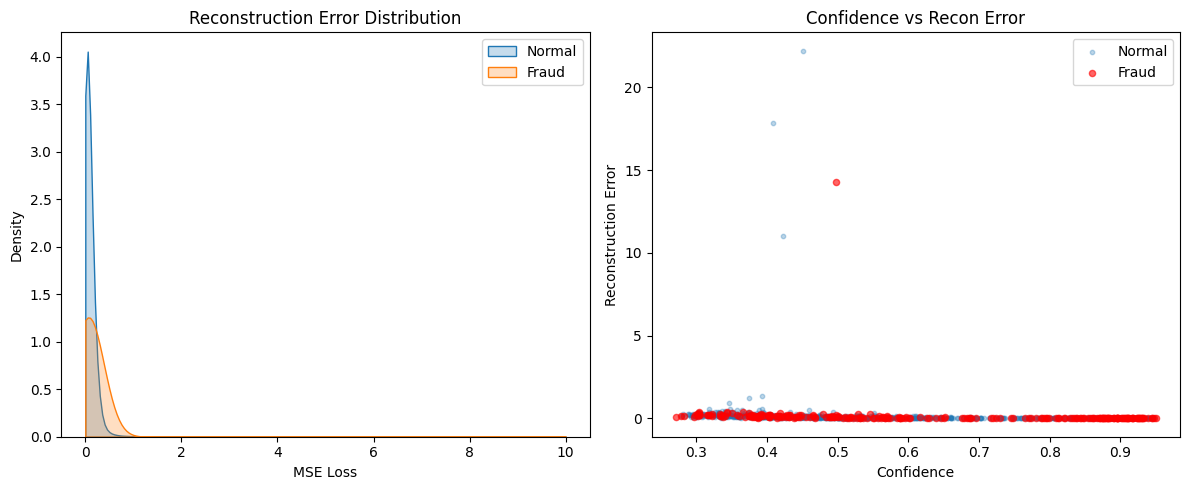


--- Final Evaluation on Test Data ---
Using Threshold: 14.3167
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56863
       Fraud       0.94      0.46      0.61       246

    accuracy                           1.00     57109
   macro avg       0.97      0.73      0.81     57109
weighted avg       1.00      1.00      1.00     57109

Confusion Matrix:
[[56856     7]
 [  134   112]]

Test ROC-AUC: 0.9468


In [6]:
# 1. 学習データで閾値を決定
print("\n--- Analyzing Training Data to determine threshold ---")
recon_train, conf_train, win_train, gate_train = evaluate_anomaly_detection_with_gate(model, train_loader, device=device)
# 評価結果のプロットと最適閾値の計算
best_threshold = analyze_and_plot_results(y_train.numpy(), recon_train, conf_train, win_train, gate_train)

# 2. テストデータでの最終評価
print("\n--- Final Evaluation on Test Data ---")
recon_test, _, _, _ = evaluate_anomaly_detection_with_gate(model, test_loader, device=device)
y_true_test = y_test.numpy()

# 予測 (閾値判定)
y_pred_test = (recon_test > best_threshold).astype(int)

# レポート表示
print(f"Using Threshold: {best_threshold:.4f}")
print(classification_report(y_true_test, y_pred_test, target_names=["Normal", "Fraud"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true_test, y_pred_test))

roc_test = roc_auc_score(y_true_test, recon_test)
print(f"\nTest ROC-AUC: {roc_test:.4f}")